In [6]:
%load_ext autoreload
%autoreload 2

import os
import sys
sys.path.append('../')

import torch
import utils
import plots
from collections import Counter
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets
from captum.attr import IntegratedGradients
from lfxai.explanations.features import attribute_auxiliary

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
def eval_img(model, vae, val_data_t, val_pil_data, concepts, device, threshold=0.05):
    attr_method = IntegratedGradients(vae)
    baseline = torch.zeros((1, len(concepts)))
    
    concept_counter = Counter()

    with torch.no_grad():
        for i in range(len(val_data_t)):
            image, label = val_pil_data[i]
            x, l = val_data_t[i]
            x = x.unsqueeze(0).to(device)
            display(image.resize([320,320]))
            
            concept_act = model(x)
            concept_act = concept_act.double()
        
            test_loader = DataLoader(TensorDataset(concept_act, concept_act), batch_size=1, shuffle=False)
            
            feature_importance = attribute_auxiliary(vae.encoder.to(torch.device('cpu')), test_loader, 
                                                     'cpu', attr_method, baseline)
            
            contributions = concept_act[0]* torch.from_numpy(feature_importance).squeeze().to(device)
            #contributions = concept_act[0]*model.final.weight[top_classes[0], :]
        
            feature_names = [("NOT " if concept_act[0][i] < 0 else "") + concepts[i] for i in range(len(concepts))]
            values = contributions.cpu().numpy()

            activated_concepts = [feature for feature, value in zip(feature_names, values) if abs(value) > threshold]
            concept_counter.update(activated_concepts)
            
            max_display = min(int(sum(abs(values)>0.005))+1, 8)
            title = "Pred"
            plots.bar(values, feature_names, max_display=max_display, title=title, fontsize=16)

    return concept_counter

In [8]:
dataset = 'imagenet'
latent_dim = 256
hidden_dim = latent_dim*2
vae_epoch = 100
input_dim = 7501
device = 'cuda:1'
base_load_path = f'../saved_models_gpt4/{dataset}/base-resnet'
concept_load_path = f'{base_load_path}/cbm_resnet50/'
vae_load_path = f'{base_load_path}/vae/imagenet_both_z{latent_dim}_bn_e{vae_epoch}.pth'

with open(os.path.join(concept_load_path, "concepts.txt"), "r") as f:
    concepts = f.read().split("\n")

In [10]:
vae = utils.load_vae(vae_load_path, len(concepts), hidden_dim, latent_dim).double().to(device)
cbm_pipline, target_preprocess = utils.load_cbm_pipline(concept_load_path, device)

val_data_t = datasets.ImageFolder(root='../external_dataset', transform=target_preprocess)
val_pil_data = datasets.ImageFolder(root='../external_dataset')

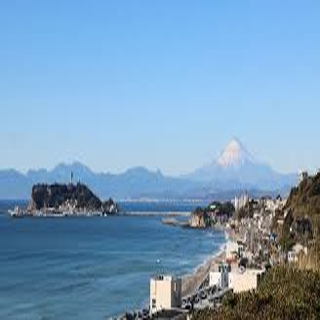

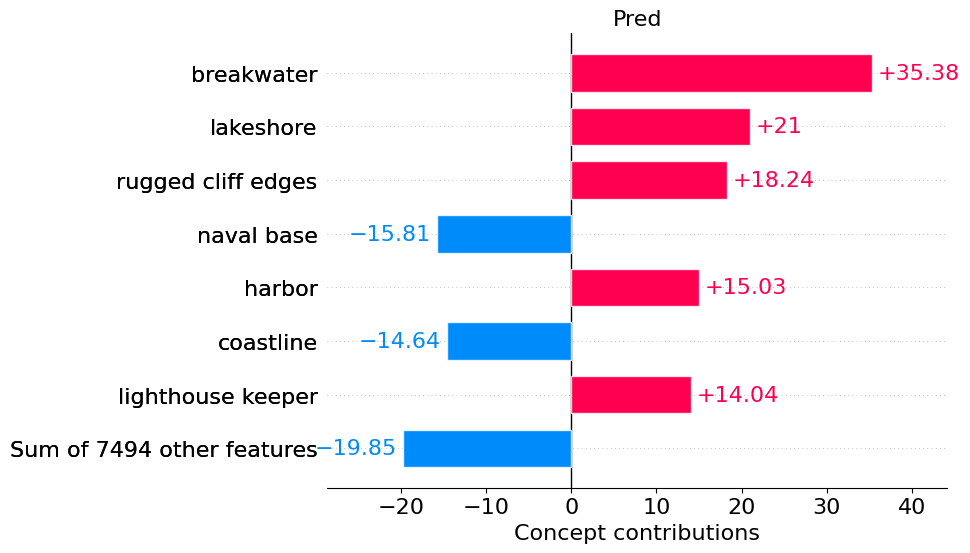

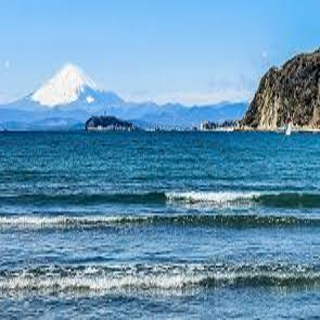

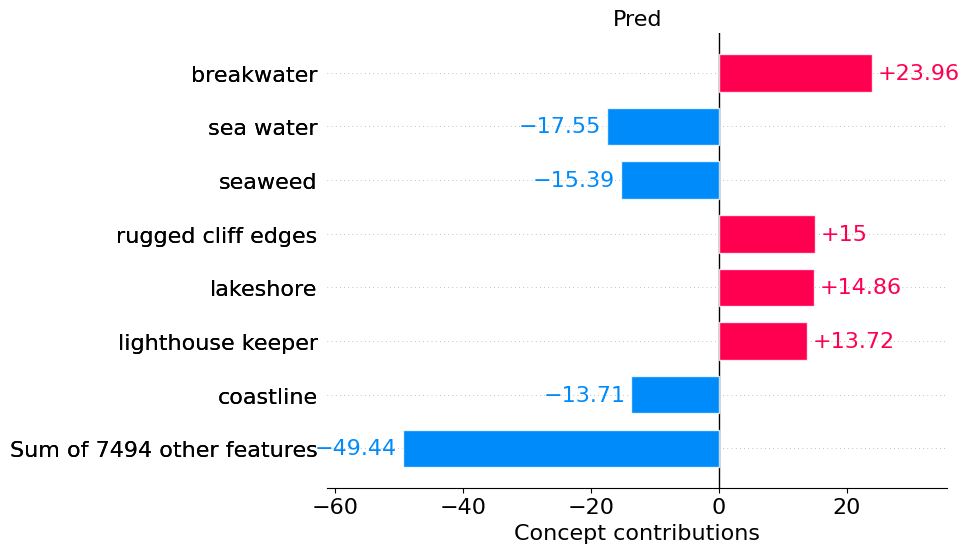

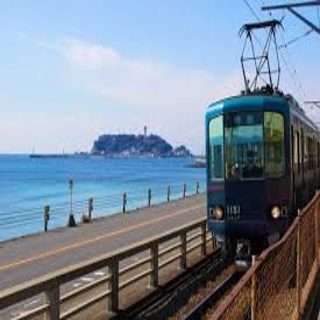

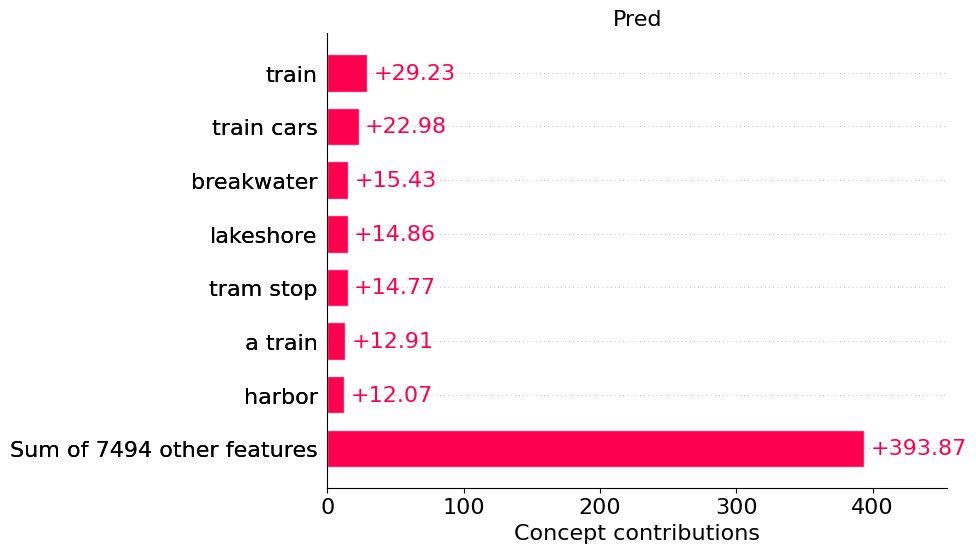

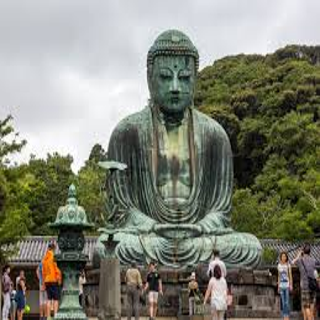

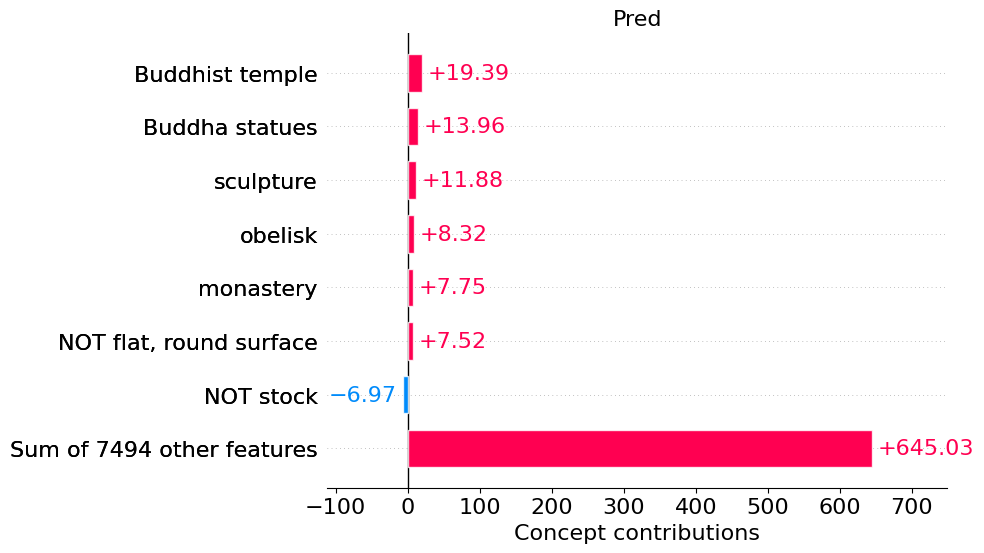

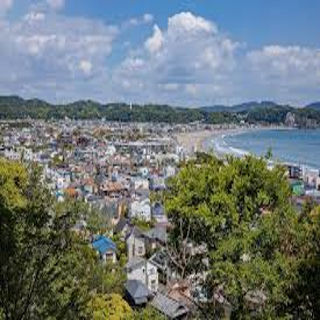

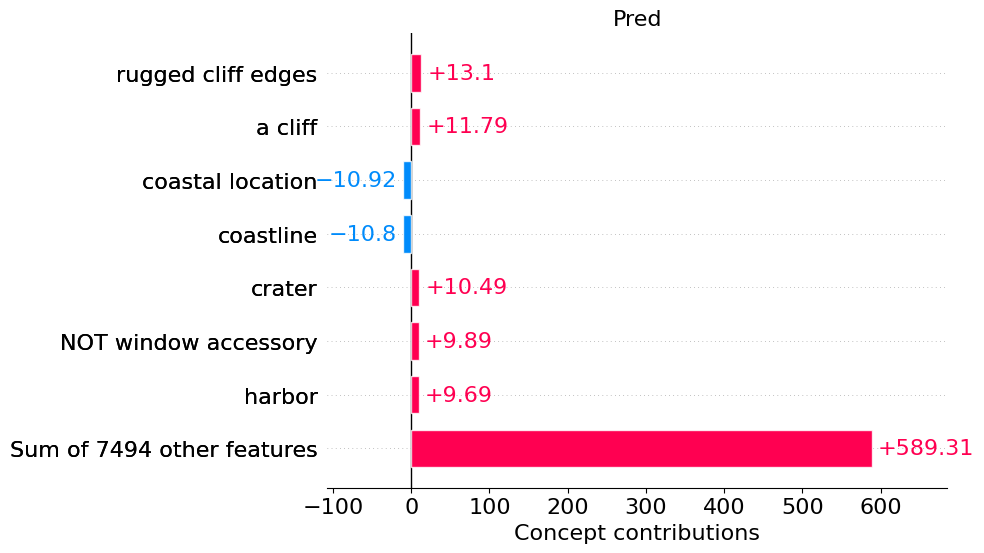

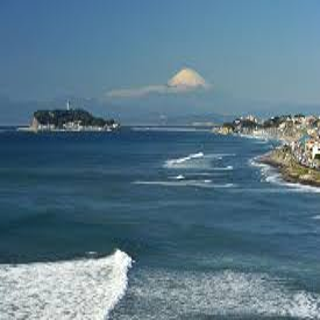

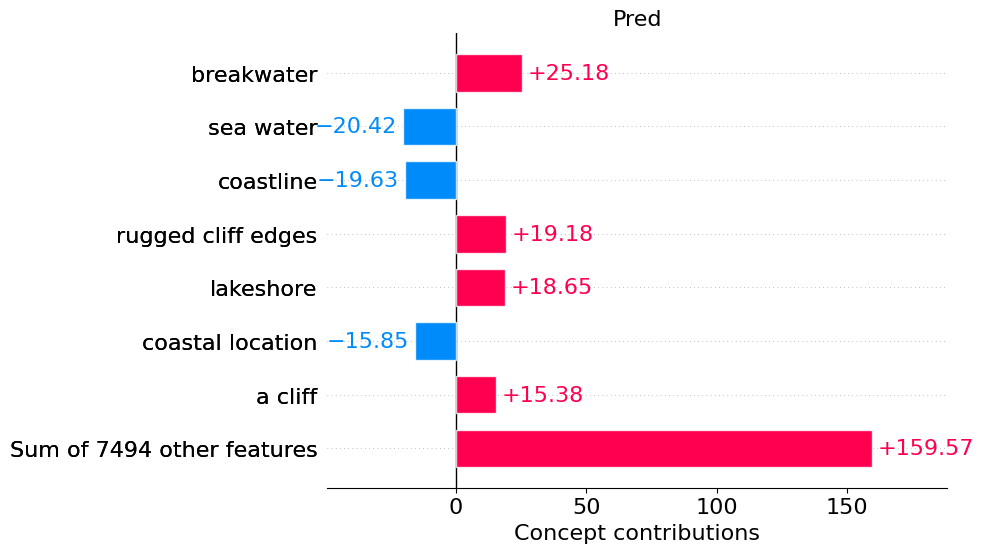

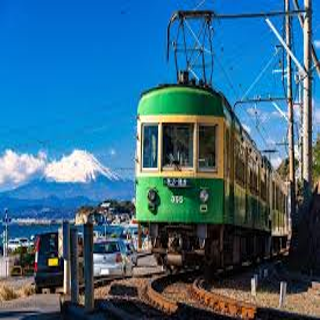

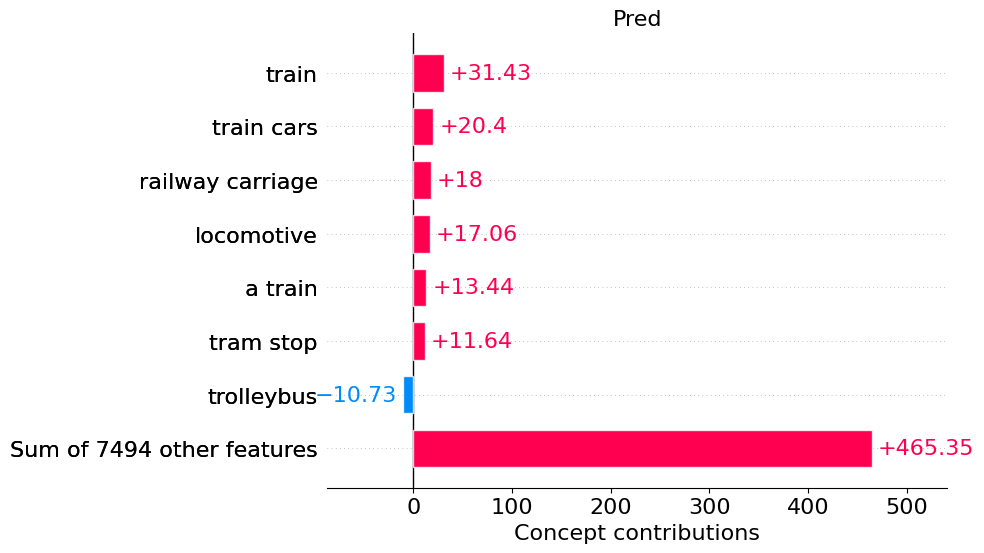

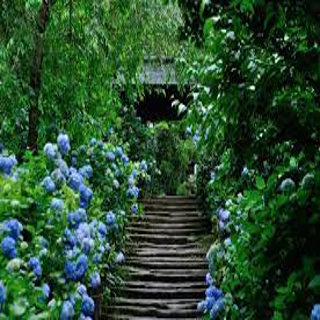

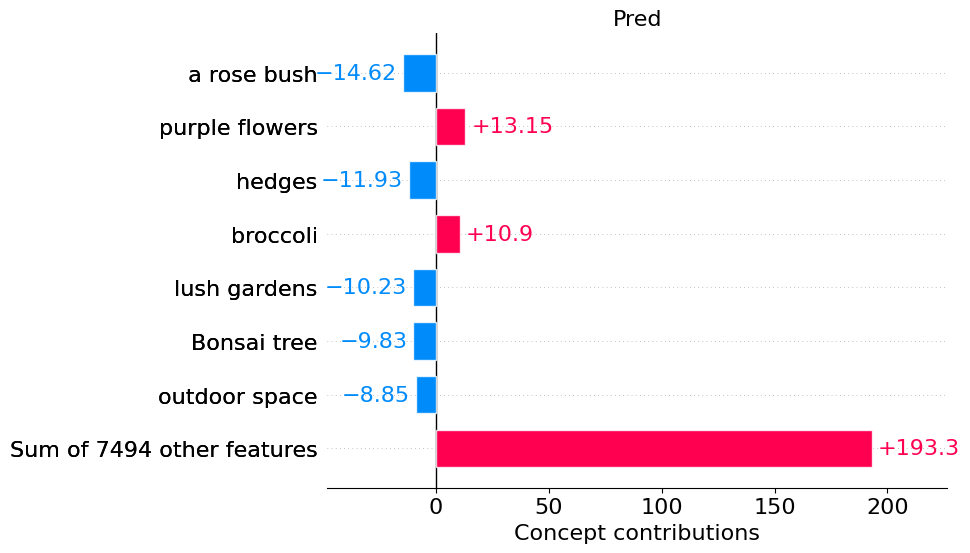

In [14]:
concept_counter = eval_img(cbm_pipline, vae, val_data_t, val_pil_data, concepts, device)

In [21]:
concept_counter

Counter({'cruise ship terminal': 10,
         'drilling platform': 8,
         'a boat': 8,
         'impressive expanse': 8,
         'an island': 8,
         'train cars': 7,
         'dock or ramp': 7,
         'sea border location': 7,
         'blue and white exterior': 7,
         'a baseball field': 7,
         'a university': 7,
         'distressed passengers': 6,
         'train': 6,
         ' a train': 6,
         ' ice rink': 6,
         'high-speed train': 6,
         'lighthouse keeper': 6,
         'blue sea water': 6,
         ' a dam': 6,
         'mooring posts': 6,
         'a football field': 6,
         'a town': 6,
         'erupting water stream': 6,
         'prayer wheels': 6,
         'cabins': 6,
         ' Buddhist temple': 6,
         'Platform': 5,
         'transport': 5,
         'top rail': 5,
         'tram stop': 5,
         'freight yard': 5,
         'high side rails': 5,
         'other vehicles': 5,
         'transport component': 5,
         'fi